# Melting Dynamics

This is a notebook to understand the dynamics of crystal melting, in particular how much of the slowdown of the melting can be attributed to the slow dynamics.

In [1]:
# Import required modules
import pandas
import numpy as np
import altair.vegalite.v2 as alt
from ipywidgets import interact, ToggleButtons, IntSlider
from uncertainties import unumpy

import sys
sys.path.append('../src')
import figures

figures.use_my_theme()

## Input data

The data for this notebook is sourced from the calculations of the relaxation times which can be run using the makefile in the home directory of this repository. The command `make relaxations` will compute the relaxation values that are required for this analysis, although if not run previously the command `make dynamics` will also need to be run as I am yet to set up any dependencies in the Makefile.

The calculation of the melting rates is performed in the [Crystal_Clustering](Crystal_Clustering.ipynb) notebook from calculations of crystal fractions from running `make melting`.

In [2]:
with pandas.HDFStore("../data/analysis/dynamics_clean_agg.h5") as src:
    mol_relax_df = src.get("molecular_relaxations")
    
with pandas.HDFStore("../data/analysis/dynamics_clean_agg.h5") as src:
    relax_df = src.get("relaxations")
    
with pandas.HDFStore("../data/analysis/melting_clean.h5") as src:
    melting_df = src.get("rates")

timescales_df = relax_df.merge(melting_df, on=['temperature', 'pressure'])

## Timescale normalised rates

We want to be able to determine whether the timescale of the dynamics 
is solely responsible for the drastic slowdown in melting rate that we observe.
We have the melting rate,
which is the distance the interface travels per unit time

$ \frac{d}{t} $

The other quantity is the rotational relaxation time
which is the timescale on which the rotations take place.

$ {t} $

In multiplying these two quantities together
we should get the distance the interface moves
in the characteristic timescale.

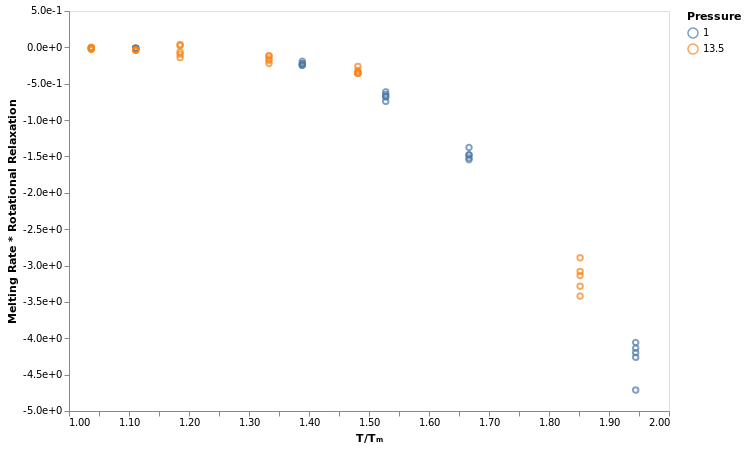

In [3]:
c = alt.Chart(timescales_df).mark_point().encode(
    x=alt.X('temp_norm', title='T/Tₘ', scale=alt.Scale(zero=False)),
    y=alt.Y("scaling:Q", title='Melting Rate * Rotational Relaxation', axis=alt.Axis(format='e')),
    color=alt.Color("pressure:N", title="Pressure"),
).transform_calculate(
    scaling = alt.datum.mean * alt.datum.rot2_value
)

c

In [4]:
c.save("../figures/normalised_melting.svg", webdriver="firefox")

In [5]:
import scipy.optimize

In [6]:
def fit_curve(x_vals, y_vals, errors=None, delta_E=None):
    if delta_E is None:
        def theory(x, c, d):
            result = 1 - np.exp((1-x) * d / x)
            return c * result
    else:
        def theory(x, c):
            result = 1 - np.exp((1-x) * delta_E / x)
            return c * result
    
    opt, err = scipy.optimize.curve_fit(
        theory, 
        x_vals, 
        y_vals,
        sigma=errors,
        maxfev=2000,
    )
    
    return theory, opt, err

In [7]:
df_1 = timescales_df.query("pressure == 1.00")
 

df_fit = pandas.DataFrame({
    "temp_norm": df_1.temp_norm, 
    "scaling": df_1["mean"] * df_1["struct_value"],
})

theory, opt, err = fit_curve(df_fit["temp_norm"], df_fit["scaling"])

df_fit["theory"] = theory(df_1.temp_norm, *opt)

In [8]:
opt

array([ 2.80445837e-04, -1.93421398e+01])

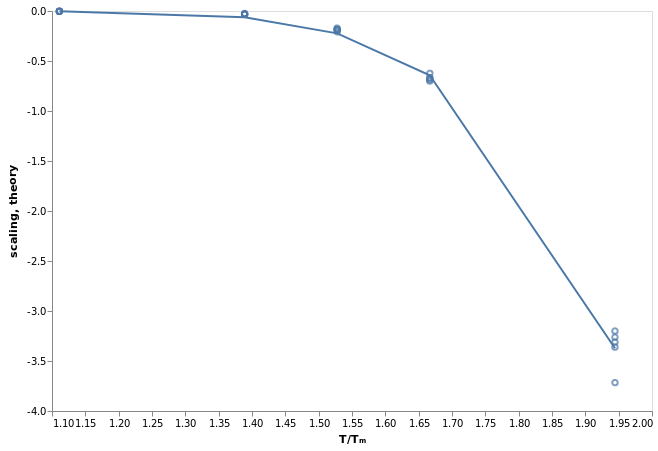

In [9]:
c = alt.Chart(df_fit).encode(
    x=alt.X('temp_norm', title='T/Tₘ', scale=alt.Scale(zero=False)),
)

c.mark_point().encode(y="scaling") + c.mark_line().encode(y="theory")

In [10]:
print(f"""
The above plot uses the values computed from the curve fit with;
- enthalpy: {opt[1]:.3f}, and
- constant: {opt[0]:.3f}
""")


The above plot uses the values computed from the curve fit with;
- enthalpy: -19.342, and
- constant: 0.000



In [11]:
df_13 = timescales_df.query("pressure == 13.50")
 
df_fit = pandas.DataFrame({
    "temp_norm": df_13.temp_norm, 
    "scaling": df_13["mean"] * df_13["rot2_value"],
})

theory, opt, err = fit_curve(df_fit["temp_norm"], df_fit["scaling"])
# theory, opt, err = fit_curve(df_13)

df_fit["theory"] = theory(df_13.temp_norm, *opt)

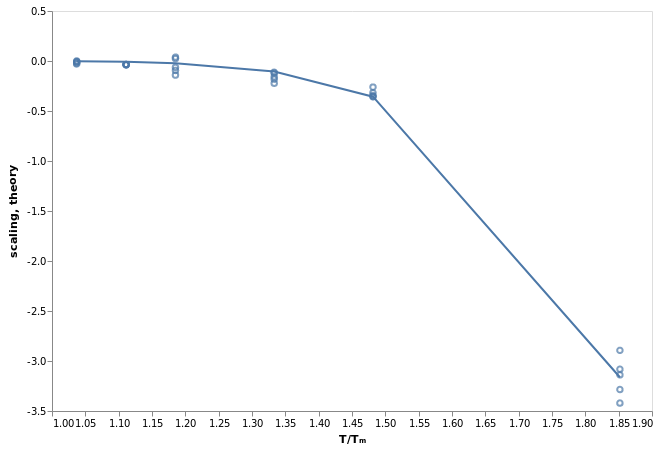

In [12]:
c = alt.Chart(df_fit).encode(
    x=alt.X('temp_norm', title='T/Tₘ', scale=alt.Scale(zero=False)),
)

c.mark_point().encode(y="scaling") + c.mark_line().encode(y="theory")

In [13]:
print(f"""
The above plot uses the values computed from the curve fit with;
- enthalpy: {opt[1]:.3f}, and
- constant: {opt[0]:.3f}
""")


The above plot uses the values computed from the curve fit with;
- enthalpy: -16.125, and
- constant: 0.002

